In [40]:
import os

import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

from cropEyeRegion import getCroppedEyeRegion
from dataPath import DATA_PATH
%matplotlib inline

In [41]:
import matplotlib

matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)
matplotlib.rcParams['image.cmap'] = 'gray'

In [42]:
predications2Lable = {0: "No Glasses", 1: "With Glasses"}

# Path1 is class 0 and Path2 is class 1
path1 = DATA_PATH + 'images/glassesDataset/cropped_withoutGlasses2'
path2 = DATA_PATH + 'images/glassesDataset/cropped_withGlasses2'

In [43]:
def getTrainTest(path, class_val, test_fraction=0.2):
    testData = []
    trainData = []
    trainLabels = []
    testLabels = []
    inputDir = os.path.expanduser(path)

    # Get images from the directory and find number of train
    # and test samples
    if os.path.isdir(inputDir):
        images = os.listdir(inputDir)
        images.sort()
        nTest = int(len(images) * test_fraction)

    for counter, img in enumerate(images):

        im = cv.imread(os.path.join(inputDir, img))
        # Add nTest samples to testing data
        if counter < nTest:
            testData.append(im)
            testLabels.append(class_val)
        else:
            # Add nTrain samples to training data
            trainData.append(im)
            trainLabels.append(class_val)

    return trainData, trainLabels, testData, testLabels

SVM Classifier


In [44]:
def svmInit(C, gamma):
    model = cv.ml.SVM_create()
    model.setGamma(gamma)
    model.setC(C)
    model.setKernel(cv.ml.SVM_RBF)
    model.setType(cv.ml.SVM_C_SVC)
    return model


def svmTrain(model, samples, responses):
    model.train(samples, cv.ml.ROW_SAMPLE, responses)
    return model


def svmPredict(model, samples):
    return model.predict(samples)[1].ravel()


def svmEvaluate(model, samples, lables):
    predictions = svmPredict(model, samples)
    accuracy = (lables == predictions).mean()
    print("Percentage Accuracy: %.2f %%" % (accuracy * 100))
    return accuracy


def prepareData(data):
    featureVectorLength = len(data[0])
    features = np.float32(data).reshape(-1, featureVectorLength)
    return features


HOG Feature Descriptor

In [45]:
def computeHog(hog, data):
    hogData = []
    for image in data:
        hogFeatures = hog.compute(image)
        hogData.append(hogFeatures)

    return hogData


# Initialize hog parameters
winSize = (96, 32)
blockSize = (8, 8)
blockStride = (8, 8)
cellSize = (4, 4)
nbins = 9
derivAperture = 0
winSigma = 4.0
histogramNormType = 1
L2HysThreshold = 2.0000000000000001e-01
gammaCorrection = 1
nlevels = 64

hog = cv.HOGDescriptor(winSize, blockSize, blockStride, cellSize,
                       nbins, derivAperture, winSigma,
                       histogramNormType, L2HysThreshold,
                       gammaCorrection, nlevels, 1)

Load Data into Train and Test variables

In [46]:
negTrainImages, negTrainLabels, negTestImages, negTestLabels = getTrainTest(path1, 0, .2)
posTrainImages, posTrainLabels, posTestImages, posTestLabels = getTrainTest(path2, 1, .2)

# Train Images
trainImages = np.concatenate((np.array(negTrainImages), np.array(posTrainImages)), axis=0)
testImages = np.concatenate((np.array(negTestImages), np.array(posTestImages)), axis=0)

# Train Labels
trainLabels = np.concatenate((np.array(negTrainLabels), np.array(posTrainLabels)), axis=0)
testLabels = np.concatenate((np.array(negTestLabels), np.array(posTestLabels)), axis=0)


In [47]:
trainHog = computeHog(hog, trainImages)
testHog = computeHog(hog, testImages)

trainFeatures = prepareData(trainHog)
testFeatures = prepareData(testHog)

Train the SVM Model

In [48]:
model = svmInit(C=2.5, gamma=0.02)
model = svmTrain(model, trainFeatures, trainLabels)
model.save("eyeGlassClassifierModel.yml")


Evaluate the mdoel and check the accuracy

In [55]:
savedModel = cv.ml.SVM_load("eyeGlassClassifierModel.yml")
accuracy = svmEvaluate(savedModel, testFeatures, testLabels)


Percentage Accuracy: 44.97 %


Check the result

[[181 128 244 244]]
Eye Height between : 40,122
Prediction = With Glasses


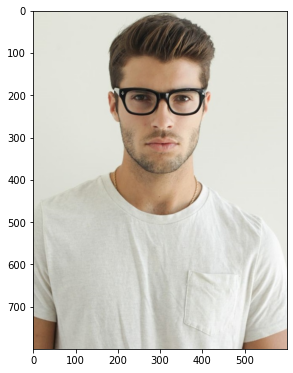

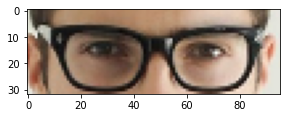

In [54]:
filename = DATA_PATH + "images/glassesDataset/glasses_4.jpg"
filename = "/Users/admin/Pictures/glasses.jpeg"
testImage = cv.imread(filename)
cropped = getCroppedEyeRegion(testImage)
testHog = computeHog(hog, np.array([cropped]))
testFeatures = prepareData(testHog)
predictions = svmPredict(savedModel, testFeatures)
print("Prediction = {}".format(predications2Lable[int(predictions[0])]))

plt.subplot(121);
plt.imshow(testImage[..., ::-1]);
plt.show()
plt.subplot(122);
plt.imshow(cropped[..., ::-1]);
plt.show()

[[458 268 190 190]]
Eye Height between : 31,95
Predictions = No Glasses


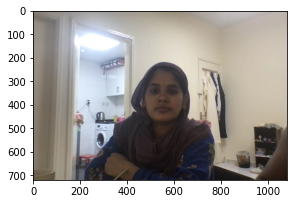

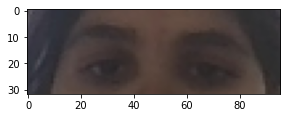

In [53]:
filename = DATA_PATH + "images/glassesDataset/no_glasses1.jpg"
filename = "/Users/admin/Pictures/noGlasses.jpg"
testImage = cv.imread(filename)
cropped = getCroppedEyeRegion(testImage)
testHog = computeHog(hog, np.array([cropped]))
testFeatures = prepareData(testHog)
predictions = svmPredict(savedModel, testFeatures)
print("Predictions = {}".format(predications2Lable[int(predictions[0])]))

plt.subplot(121);
plt.imshow(testImage[..., ::-1]);
plt.show()
plt.subplot(122);
plt.imshow(cropped[..., ::-1]);
plt.show()